<h1 align="center">Denoising Process</h1> 

In [1]:
import lovely_tensors as lt
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt

from ldm.modules.encoders.modules import FrozenOpenCLIPEmbedder
from ldm.modules.diffusionmodules.openaimodel import UNetModel
from ldm.models.autoencoder import AutoencoderKL

from helper import ForwardDiffusionProcessor, X2imgs, imgs2X

lt.monkey_patch()

/home/chris/miniconda3/envs/stable-diffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.


In [2]:
# laod the weights

ckpt = "v2-1_512-ema-pruned.ckpt"
state_dict = torch.load(ckpt, map_location="cpu")["state_dict"]

state_dict_vae = {}
state_dict_unet = {}
state_dict_clip_embedder = {}

for k, v in state_dict.items():
    if k.startswith("first_stage_model."):
        state_dict_vae[k.replace("first_stage_model.", "")] = v
    elif k.startswith("model.diffusion_model."):
        state_dict_unet[k.replace("model.diffusion_model.", "")] = v
    elif k.startswith("cond_stage_model."):
        state_dict_clip_embedder[k.replace("cond_stage_model.", "")] = v
    else:
        pass

In [3]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the parameters
config_path = "../stablediffusion-repo/configs/stable-diffusion/v2-inference.yaml"
cfg = OmegaConf.load(config_path)

# load the variational autoencoder
vae = AutoencoderKL(**cfg.model.params.first_stage_config.params)
vae.load_state_dict(state_dict_vae, strict=True)
vae.to(device)
vae.eval()

# load the ddpm (denoising diffusion probabilistic model)
unet = UNetModel(**cfg.model.params.unet_config.params)
unet.load_state_dict(state_dict_unet, strict=True)
unet.to(device)
unet.eval()

# load the clip embedder
clip_embedder = FrozenOpenCLIPEmbedder(**cfg.model.params.cond_stage_config.params)
clip_embedder.load_state_dict(state_dict_clip_embedder, strict=True)
clip_embedder.to(device)
clip_embedder.eval()

pass

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [4]:
# Load a ForwardDiffusionProcessor, which is needed to get the corresponding
# alhpa values for out denoising process.
fdp = ForwardDiffusionProcessor()

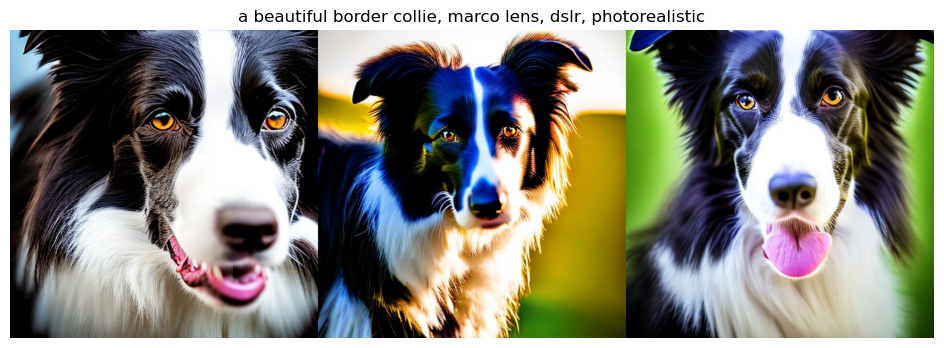

In [5]:
# Set the random seed to get reproducible results.
torch.manual_seed(0)

# Prompts from lexica.art
# prompt = "portrait of a dark god, copper wires, visible scars and nerves, intricate, headshot, highly detailed, digital painting, artstation, concept art, sharp focus, cinematic lighting, illustration, art by artgerm and greg rutkowski, alphonse mocha, cgsociety, Olivia"
# prompt = "portrait of a female pinup model in love in tropical Thailand forest lake wearing a golden Swimsuit, year 1977 with hallucinatory experience, lush magic plants, armani style : : by martine johanna and simon stalenhag and chie yoshii and casey weldon and wlop : : ornate, dynamic, particulate, rich colors, intricate, elegant, highly detailed, the vogue, harper's bazaar art, fashion magazine, smooth, sharp focus, 8 k, octane render, style of sports illustrated"
# prompt = "apex legends assassin in tactical jumpsuit. concept art by james gurney and mœbius. cinematic, dramatic lighting"

# Parameters
prompt = "a beautiful border collie, marco lens, dslr, photorealistic"
n_steps = 100
guidance_scale = 15
batch_size = 3

# Generate a random noise to start the denoising process with.
embedding_shape = (batch_size, 4, 64, 64)
Z = torch.randn(embedding_shape).to(device)

# Generate the prompt embedding. Because we are using classifier-free guidance,
# we need to generate two embedding, i.e. the embedding of our prompt and the
# embedding of the unconditioned prompt.
with torch.no_grad():
    C = clip_embedder(batch_size * [prompt])
    C_unconditioned = clip_embedder(batch_size * [""])

# Generate the timesteps.
timesteps = fdp.get_timesteps(n_steps)

# Denoise the image.
Z_evo = []
with torch.no_grad(), torch.cuda.amp.autocast():    

    # for ts in timesteps[::-1]:
    for i in reversed(range(n_steps)):

        ts = timesteps[i]
        ts_prev = timesteps[i - 1] if i > 0 else ts        
        print(f"{i:>4} | ts={ts:<3} -> ts_prev={ts_prev:<3}", end="\r")

        # Encode the timestep.
        TS = torch.full((batch_size,), ts, device=device, dtype=torch.long)

        # Estimate the noise on the image. We do this twice, once conditioned on
        # the prompt and once unconditioned.
        EPS, EPS_unconditioned = unet(
            torch.cat([Z] * 2), 
            torch.cat([TS] * 2), 
            torch.cat([C, C_unconditioned])
            ).chunk(2)

        # Combine the predicted conditioned and unconditioned noise to guide the
        # denoising process.
        EPS = EPS_unconditioned + guidance_scale * (EPS - EPS_unconditioned)

        # Calculate the denoised image. The corresponding formula can be found
        # in the following paper or in the blog post from Lilian Weng:
        # - https://arxiv.org/abs/2010.02502
        # - https://lilianweng.github.io/posts/2021-07-11-diffusion-models/    
        alpha_bar = torch.full((batch_size, 1, 1, 1), fdp.get_alpha_bar(ts), device=device)
        alpha_bar_prev = torch.full((batch_size, 1, 1, 1), fdp.get_alpha_bar(ts_prev), device=device)
        Z = alpha_bar_prev.sqrt() * (Z - (1 - alpha_bar).sqrt()*EPS) / alpha_bar.sqrt() + (1-alpha_bar_prev).sqrt() * EPS
        Z_evo.append(Z)

    # Decode the latent vector to get the final image.      
    Z_ = 1.0 / cfg.model.params.scale_factor * Z
    X = vae.decode(Z_)
    imgs = X2imgs(X)    
    
plt.figure(figsize=(batch_size*4, 4))
plt.imshow(np.hstack(imgs))
plt.axis("off")
plt.title(prompt)
plt.show()

In [6]:
# generate the gif

from tqdm import tqdm
import imageio

imgs_evo = []
with torch.no_grad(), torch.cuda.amp.autocast():    
    for Z in tqdm(Z_evo):
        Z_ = 1.0 / cfg.model.params.scale_factor * Z
        X = vae.decode(Z_)
        imgs_evo.append(X2imgs(X))

imgs_evo = np.array([np.hstack(imgs) for imgs in imgs_evo])
imageio.mimsave("imgs_evo.gif", imgs_evo, fps=10)

100%|██████████| 100/100 [00:25<00:00,  4.00it/s]
